# Injecting synthetic signals into RTL-SDR data

Before running this notebook, make sure you have collected data using the `observe.sh` script. An example script command is in `example_observation.sh`. For this tutorial, we had the RTL-SDR dongle collect 60 s of data at a center frequency of 90.3 MHz (a local FM station) at a sampling rate of 2.048 MHz, into a file `rtlsdr.dat`.

First, we enable GPU usage for `setigen` and set the used device to the first GPU.

In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if os.environ['SETIGEN_ENABLE_GPU'] == '1':
    try:
        import cupy as xp
    except ImportError:
        import numpy as xp
else:
    import numpy as xp

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, '/home/bryanb/setigen')
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

## Setup

Most of this code is identical to the first tutorial, which explains in depth how the data is collected and loaded in:

In [4]:
iq_sample_rate = 2.048e6
sample_rate = iq_sample_rate * 2
carrier_freq = 90.3e6

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=carrier_freq - iq_sample_rate / 2,
                              ascending=True,
                              num_pols=1)


num_taps = 8
num_branches = 64
fftlength = 1024
int_factor = 1

digitizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                         num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

start_chan = 0
num_chans = num_branches // 2
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=start_chan,
                                    num_chans=num_chans,
                                    block_size=33554432,
                                    blocks_per_file=128,
                                    num_subblocks=32)

# Define function to read in IQ data
f = open('rtlsdr.dat', 'rb')

def iq_signal(f):
    """f is the file handler"""
    def sub_func(ts):
        num_samples = len(ts)

        iq = f.read(num_samples)

        iq = xp.array(np.frombuffer(iq, dtype=np.uint8), dtype='float')
        iq -= 128
        iq = iq[0::2] + iq[1::2] * 1j

        # IQ bandwidth is iq_sample_rate, so shift by half
        shift_freq = iq_sample_rate / 2
        iq_shifted = iq * xp.exp(1j * 2 * xp.pi * shift_freq * ts[0::2])

        v = xp.zeros(num_samples, dtype='complex')
        v[0::2] = iq_shifted
        return v
    return sub_func

antenna.x.add_signal(iq_signal(f))

## Injection

Now we can do things like inject noise and synthetic signals:

In [5]:
# Add synthetic signals
antenna.x.add_noise(0, 1)

level = stg.voltage.get_level(snr=3e4, 
                              raw_voltage_backend=rvb,
                              fftlength=fftlength,
                              obs_length=60, 
                              length_mode='obs_length')

unit_drift_rate = stg.voltage.get_unit_drift_rate(rvb,
                                                  fftlength=fftlength,
                                                  int_factor=int_factor)

# Update noise stats, and reset file pointer
antenna.x.update_noise()
f.seek(0)

antenna.x.add_constant_signal(f_start=90.9e6, 
                              drift_rate=0.2e6/60,
                              level=antenna.x.get_total_noise_std()*level*np.sqrt(0.2e6/60/unit_drift_rate))

We do a few things here. One is to get the corresponding intensity for a desired SNR level. Then, we also try to account for the loss in intensity of a drifting signal, which generally goes as the inverse of the drift rate. Of course, since the original signal is in voltage space, we have to take the square root to get the appropriate scaling. 

We also try to estimate the noise level of injected noise using `DataStream.update_noise()`, which manually takes some samples and estimates the standard deviation (using magnitudes for complex numbers). Since our function steps through the input data file, we make sure to reset the file pointer before collecting data. 

## Recording synthetic data
We can now record the data in GUPPI RAW format. In this example, the recording has about 60 seconds of data.

In [6]:
rvb.record(raw_file_stem='rtlsdr',
           obs_length=60, 
           length_mode='obs_length',
           header_dict={},
           verbose=False)

f.close()

Blocks: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]     


## Taking a look
If `rawspec` is installed, you can unpack the data as such:

In [7]:
!rawspec -f $fftlength -t $int_factor rtlsdr

working stem: rtlsdr
opening file: rtlsdr.0000.raw
opening file: rtlsdr.0001.raw [No such file or directory]
output product 0: 3584 spectra


Using `blimpy` to open the resulting filterbank file and plotting the data:

/datax/scratch/bbrzycki/miniconda3/envs/bl_tf/lib/python3.8/site-packages/blimpy/utils.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


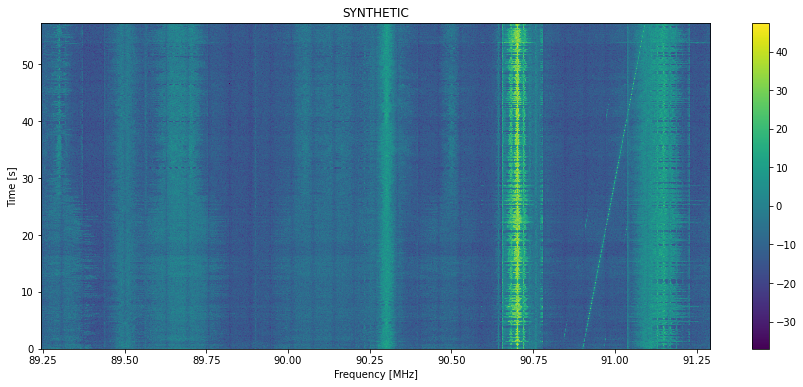

Dimensions (df, dt): (62.5 Hz, 0.016 s)


In [8]:
frame = stg.Frame('rtlsdr.rawspec.0000.fil')

plt.figure(figsize=(15, 6))
frame.bl_render()
plt.show()

print(f'Dimensions (df, dt): ({frame.df} Hz, {frame.dt} s)')

There's our signal, drifting between 90.9 and 91.1 MHz!

Integrating over time, and marking the boundaries of the coarse channels:

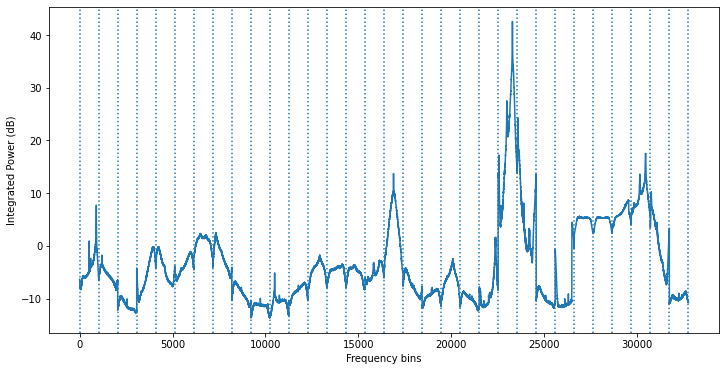

In [9]:
x = stg.db(frame.data.mean(axis=0))

plt.figure(figsize=(12, 6))
plt.plot(x)
for i in range(num_branches // 2 + 1):
    plt.axvline(i * frame.fchans / (num_branches // 2), ls=':')
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()